In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="IBM"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_adx = ed.eland_to_pandas(df_eod)[::-1].tail(100).set_index('date_reference')

In [4]:
period = 14

# Calculate +DM, -DM, and TR
df_adx['prev_high'] = df_adx['val_high'].shift(1)
df_adx['prev_low'] = df_adx['val_low'].shift(1)
df_adx['prev_close'] = df_adx['val_close'].shift(1)

df_adx['plus_dm'] = np.where((df_adx['val_high'] - df_adx['prev_high']) > (df_adx['prev_low'] - df_adx['val_low']),
                             df_adx['val_high'] - df_adx['prev_high'], 0)
df_adx['plus_dm'] = np.where(df_adx['plus_dm'] > 0, df_adx['plus_dm'], 0)  # Ensure non-negative

df_adx['minus_dm'] = np.where((df_adx['prev_low'] - df_adx['val_low']) > (df_adx['val_high'] - df_adx['prev_high']),
                              df_adx['prev_low'] - df_adx['val_low'], 0)
df_adx['minus_dm'] = np.where(df_adx['minus_dm'] > 0, df_adx['minus_dm'], 0)  # Ensure non-negative

df_adx['tr'] = np.maximum(df_adx['val_high'] - df_adx['val_low'],
                          np.maximum(abs(df_adx['val_high'] - df_adx['prev_close']),
                                     abs(df_adx['val_low'] - df_adx['prev_close'])))

# Drop initial NaN rows
df_adx.dropna(inplace=True)

# Smooth using Wilder's method (ewm equivalent)
plus_dm_smooth = df_adx['plus_dm'].ewm(com=period-1, adjust=False).mean()
minus_dm_smooth = df_adx['minus_dm'].ewm(com=period-1, adjust=False).mean()
tr_smooth = df_adx['tr'].ewm(com=period-1, adjust=False).mean()

# Calculate +DI and -DI
df_adx['plus_di'] = 100 * (plus_dm_smooth / tr_smooth)
df_adx['minus_di'] = 100 * (minus_dm_smooth / tr_smooth)

# Calculate DX
dx = 100 * abs(df_adx['plus_di'] - df_adx['minus_di']) / (df_adx['plus_di'] + df_adx['minus_di'])

# Calculate ADX (smooth DX)
df_adx['adx'] = dx.ewm(com=period-1, adjust=False).mean()

In [5]:
df_adx.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,prev_high,prev_low,prev_close,plus_dm,minus_dm,tr,plus_di,minus_di,adx
date_reference,,,,,,,,,,,,,,,
2025-10-17,IBM,281.28,283.4000,275.3500,276.15,5309565,282.56,275.60,275.97,0.84,0.0000,8.0500,27.878634,18.233010,36.129152
2025-10-20,IBM,283.65,285.5000,280.9600,281.25,3494336,283.40,275.35,281.28,2.10,0.0000,4.5400,28.735886,17.382469,35.306927
2025-10-21,IBM,282.05,285.3100,281.6000,283.31,4080981,285.50,280.96,283.65,0.00,0.0000,3.7100,27.602725,16.697015,34.543432
2025-10-22,IBM,287.51,289.1700,281.3500,281.99,10538480,285.31,281.60,282.05,3.86,0.0000,7.8200,29.390319,15.325214,34.322803
2025-10-23,IBM,285.00,285.5791,263.5623,264.95,16676394,289.17,281.35,287.51,0.00,17.7877,23.9477,23.124631,27.893137,32.538800


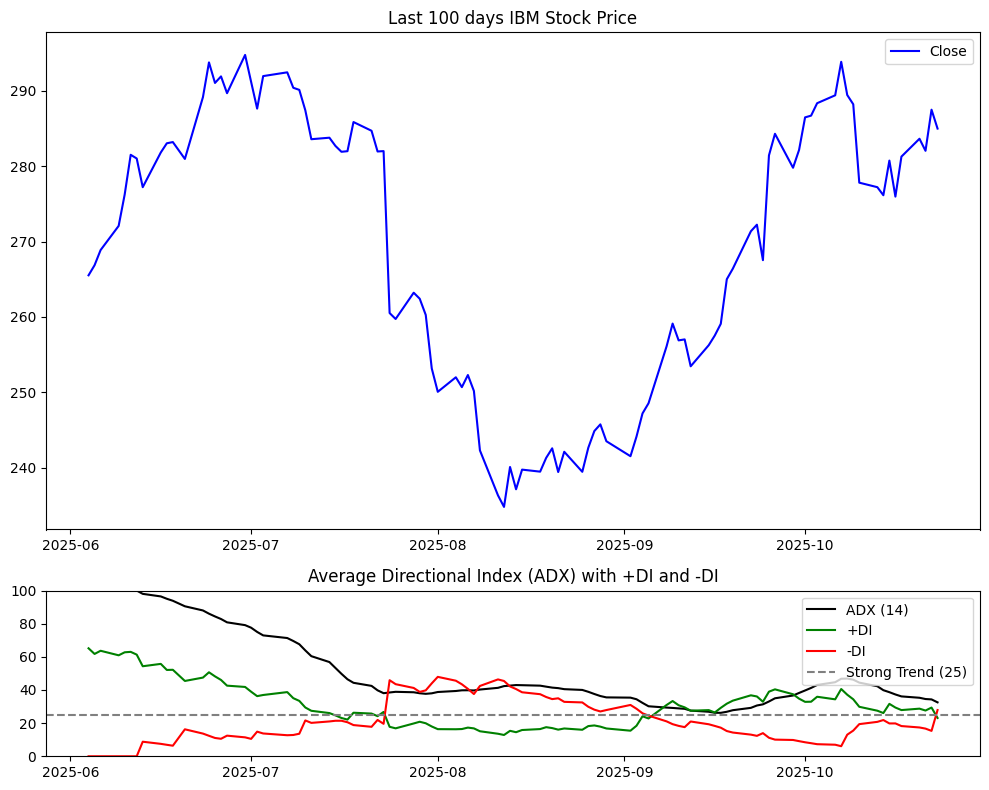

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_adx.index, df_adx['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: ADX plot with +DI and -DI
axs[1].plot(df_adx.index, df_adx['adx'], label=f"ADX ({period})", color='black')
axs[1].plot(df_adx.index, df_adx['plus_di'], label='+DI', color='green')
axs[1].plot(df_adx.index, df_adx['minus_di'], label='-DI', color='red')
axs[1].axhline(25, color='gray', linestyle='--', label='Strong Trend (25)')
axs[1].set_title('Average Directional Index (ADX) with +DI and -DI')
axs[1].legend()
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

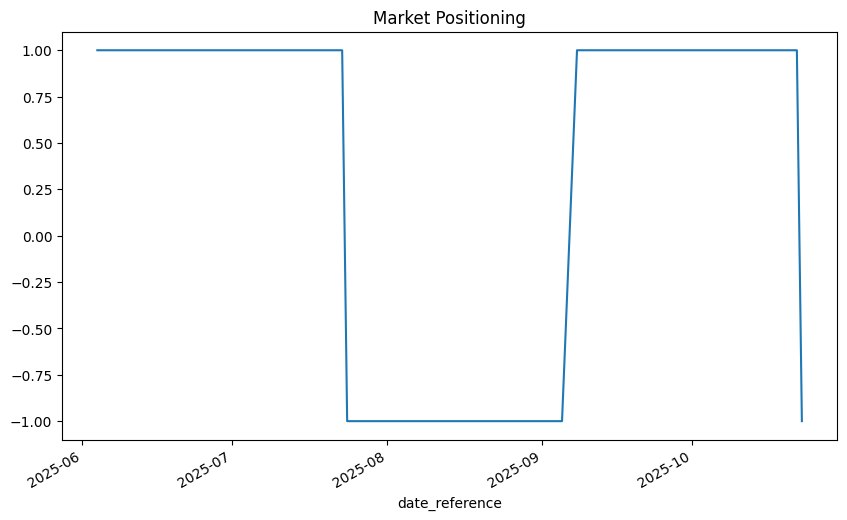

In [7]:
df_adx['position'] = np.where((df_adx['adx'] > 25) & (df_adx['plus_di'] > df_adx['minus_di']), 1, np.where((df_adx['adx'] > 25) & (df_adx['minus_di'] > df_adx['plus_di']), -1, 1))
df_adx['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_adx['returns'] = np.log(df_adx['val_close'] / df_adx['val_close'].shift(1))
df_adx['strategy'] = df_adx['position'].shift(1) * df_adx['returns']
df_adx[['returns', 'strategy']].sum().apply(np.exp)

returns     1.073365
strategy    1.110737
dtype: float64

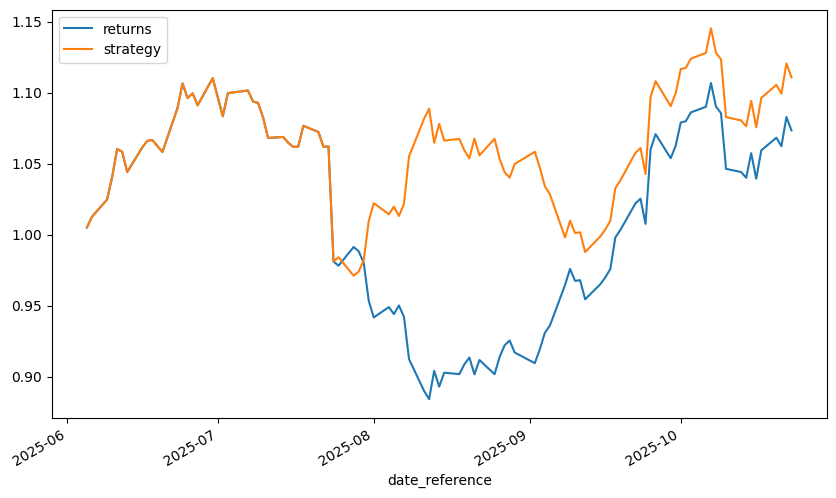

In [9]:
df_adx[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));